In [1]:
# print version / should be 1.6.3
println(versioninfo())

# load centralized paths dictionary
using YAML
PATHS_FILE = "../../../PATHS.yml"
PATHS = YAML.load_file(PATHS_FILE);

"""
    load_path(keys::Vector{String}):String

Return the absolute path for a requested item within the nested PATHS dictionary.
"""
function loadpath(keys::Vector{String}):String
    # recusively assemble paths from keys
    requested_path = foldl((x, y) -> getindex(x, y), keys; init=PATHS)
    # rephrase abs path from relative paths to be platform independent.
    realpath(joinpath(splitdir(realpath(PATHS_FILE))[1], requested_path))
end;

Julia Version 1.6.3
Commit ae8452a9e0 (2021-09-23 17:34 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, haswell)
Environment:
  __LMOD_REF_COUNT_JULIA_DEPOT_PATH = /home/biotoml/.julia:1;/sw/comp/julia/1.6.3/rackham/lib/glob_pkg:1
  JULIA_DEPOT_PATH = /home/biotoml/lsm/src/.julia/v1.6_depot:/home/biotoml/.julia:/sw/comp/julia/1.6.3/rackham/lib/glob_pkg
  __LMOD_REF_COUNT_JULIA_LOAD_PATH = @:1;@v#.#:1;@stdlib:1;/sw/comp/julia/1.6.3/rackham/lib/glob_pkg/environments/v1.6:1
  JULIA_PROJECT = /home/biotoml/lsm/src/.julia/v1.6_regrid
  JULIA_ROOT = /sw/comp/julia/1.6.3/rackham
  JULIA_LOAD_PATH = @:@v#.#:@stdlib:/sw/comp/julia/1.6.3/rackham/lib/glob_pkg/environments/v1.6
  JULIA_NUM_THREADS = 2
nothing


In [2]:
using BenchmarkTools
using IntervalSets
using NaNMath; nm=NaNMath
using NCDatasets
using Plots
using Revise
using StatsBase

In [3]:
include("./regridding.jl")
include("./spatialplotting.jl")

plot_ncdf

In [4]:
function regrid2d_datasetmt(regridder::Regridder2D, ncds::NCDataset, variables::AbstractArray{String}, operation::Function; kwargs...)
    regridder_ncds = Regridder2D(ncds; kwargs...)
    
    ncdims = keys(ncds.dim)
    dim_itvs = map(x -> dimwise_intervals(regridder)[x], ncdims)
    dim_itvs_ncds = map(x -> dimwise_intervals(regridder_ncds)[x], ncdims)
    
    regridded_ncds = init_regridded(tuple(map(x -> cardinality(regridder)[x], ncdims)...))
    for idx in CartesianIndices(axes(regridded_ncds))
        idxs = Tuple(idx)
        if idxs[1] == 1 
            print(idxs)
        end
        tile = map(((x,y),) -> x[y], zip(dim_itvs, idxs))
        rgrd_value = regrid_cell(ncds, [tile...], dim_itvs_ncds, variables, operation)
        if rgrd_value[1] > 0
            regridded_ncds[idxs...] = rgrd_value[1]
        end
    end
    
    regridded_ncds
end

function regrid2d_data(regridder::Regridder2D, ncds::NCDataset, variables::AbstractArray{String}, operation::Function; kwargs...)
    regridder_ncds = Regridder2D(ncds; kwargs...)
    ncdims = [k for k in keys(ncds.dim) if lowercase(k[1]) == 'l']
    print(ncdims)
    dim_itvs = map(x -> dimwise_intervals(regridder)[x], ncdims)
    dim_itvs_ncds = map(x -> dimwise_intervals(regridder_ncds)[x], ncdims)
    
    regridded_template = init_regridded(tuple(map(x -> cardinality(regridder)[x], ncdims)...))
    regridded_ncds = Dict(var => deepcopy(regridded_template)
        for var in variables)

    for idx in CartesianIndices(axes(regridded_template))
        println(idx)
        idxs = Tuple(idx)
        tile = map(((x,y),) -> x[y], zip(dim_itvs, idxs))
        rgrd_values = regrid_cell(ncds, [tile...], dim_itvs_ncds, variables, operation)

        for (j, var) in enumerate(variables)
            if rgrd_values[j] > 0
                regridded_ncds[var][idxs...] = rgrd_values[j]
            end
        end
    end
    regridded_ncds
end

function regrid2d_dataset(filename::String, regridder::Regridder2D, ncds::NCDataset, 
        variables::AbstractArray{String}, operation::Function; force::Bool=false, 
        kwargs...)
    # as default we avoid overwriting
    if ispath(filename) 
        !force ? (return) : rm(filename)
    end
    
    # in the first step we regrid the data
    regridded_ncds = regrid2d_data(regridder, ncds, variables, operation; kwargs...)

    # then we instantiate the new NetCDF file.
    new_ncds = NCDataset(filename,"c")
    
    # we run through all dimensions and add them
    ncdims = keys(ncds.dim)
    for ncdim in ncdims
        defDim(new_ncds, ncdim, cardinality(regridder)[ncdim])
        dim_levels = collect(ranges(regridder)[ncdim])
        defVar(new_ncds, ncdim, eltype(dim_levels), tuple(ncdim))
        new_ncds[ncdim][:] = dim_levels
    end
    
    # finally we copy the data
    for var in variables
        defVar(new_ncds, var, eltype(regridded_ncds[var]), tuple(ncdims...))
        new_ncds[var][:,:] = regridded_ncds[var]
    end
    new_ncds
end



regrid2d_dataset (generic function with 1 method)

---
---

In [5]:
file = "/home/biotoml/lsm/src/.julia/v1.7_depot/artifacts/5d6ef2052859688c2c550333981fc20f315010f7/GPP_MPI_RS_2X_1M_2019_V1.nc"

"/home/biotoml/lsm/src/.julia/v1.7_depot/artifacts/5d6ef2052859688c2c550333981fc20f315010f7/GPP_MPI_RS_2X_1M_2019_V1.nc"

In [6]:
ds = NCDataset(file, "r")

NCDataset: /home/biotoml/lsm/src/.julia/v1.7_depot/artifacts/5d6ef2052859688c2c550333981fc20f315010f7/GPP_MPI_RS_2X_1M_2019_V1.nc
Group: /

Dimensions
   lon = 720
   lat = 360
   ind = 12

Variables
  lon   (720)
    Datatype:    Float64
    Dimensions:  lon
    Attributes:
     unit                 = °
     description          = Longitude

  lat   (360)
    Datatype:    Float64
    Dimensions:  lat
    Attributes:
     unit                 = °
     description          = Latitude

  ind   (12)
    Datatype:    Int64
    Dimensions:  ind
    Attributes:
     unit                 = -
     description          = Cycle index

  data   (720 × 360 × 12)
    Datatype:    Float64
    Dimensions:  lon × lat × ind
    Attributes:
     change1              = The original lat was from north to south, and we reorgainized it from south to north
     longname             = Gross primary productivity
     about                = This content is interpolated from FLUXCOM using machine learning algori

In [8]:
rgo = Regridder2D(18,36)

Regridder2D{Int64, Float64}(RegridAxis{Int64, Float64}[RegridAxis{Int64, Float64}("lat", -90.0, 90.0, 18), RegridAxis{Int64, Float64}("lon", -180.0, 180.0, 36)])

In [9]:
new_file = "newtrial.nc";

In [10]:
regridding_op = median

a=regrid2d_dataset(new_file, rgo, ds, ["data", "std"], regridding_op; force=true);

["lon", "lat"]CartesianIndex(1, 1)


LoadError: MethodError: no method matching (::var"#21#24"{Vector{Vector{OpenInterval{Float64}}}, Vector{OpenInterval{Float64}}})()
[0mClosest candidates are:
[0m  (::var"#21#24")([91m::Any[39m) at /crex/proj/snic2022-23-321/private/thomas/notebooks/pinN1_stories/02_methodologies/regridding.jl:210

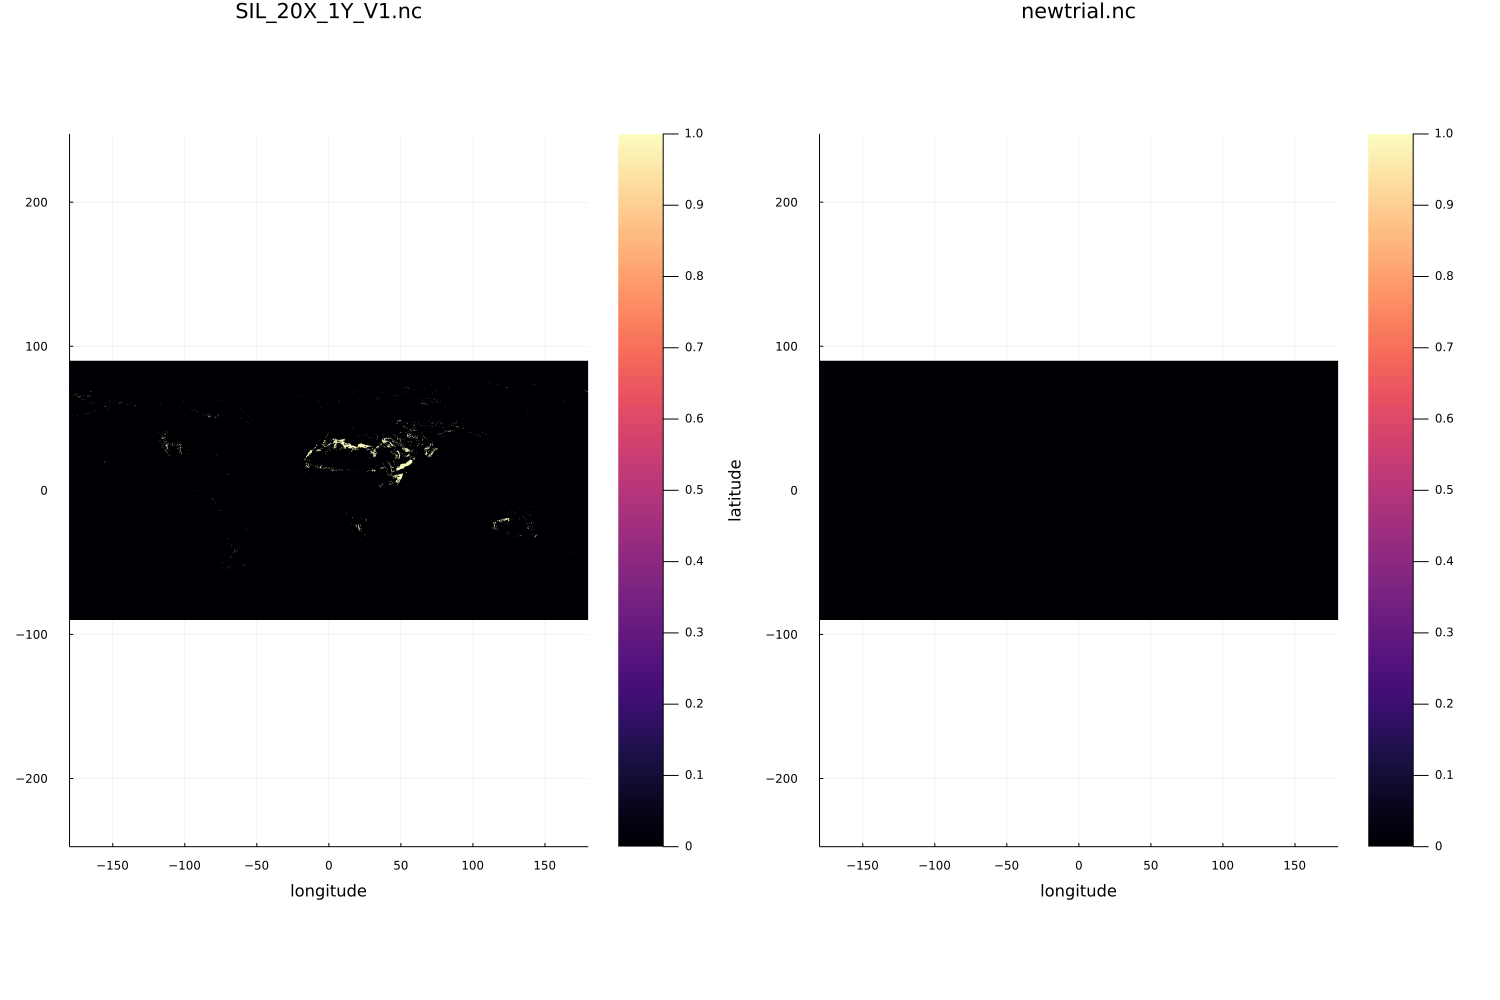

In [10]:
hmps = Dict("initial_data" => plot_ncdf(file),
            "regridded_data" => plot_ncdf(new_file))

plot(hmps["initial_data"], hmps["regridded_data"], layout = (1, 2))

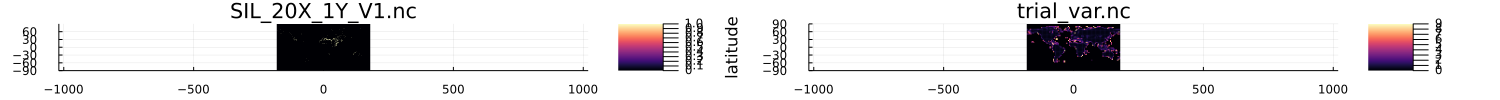

In [29]:
plot(hmps["initial_data"], hmps["regridded_data"], layout = (1, 2))
#savefig("mytestplot.pdf")

In [299]:
rgo = Regridder2D(14,99)

Regridder2D{Int64, Float64}(RegridAxis{Int64, Float64}[RegridAxis{Int64, Float64}("lat", -90.0, 90.0, 14), RegridAxis{Int64, Float64}("lon", -180.0, 180.0, 99)])

In [300]:
new_file = "trial_crazy.nc";

In [301]:
regridding_op = median

a=regrid2d_dataset(new_file, rgo, ds, ["data", "std"], regridding_op; force=true);

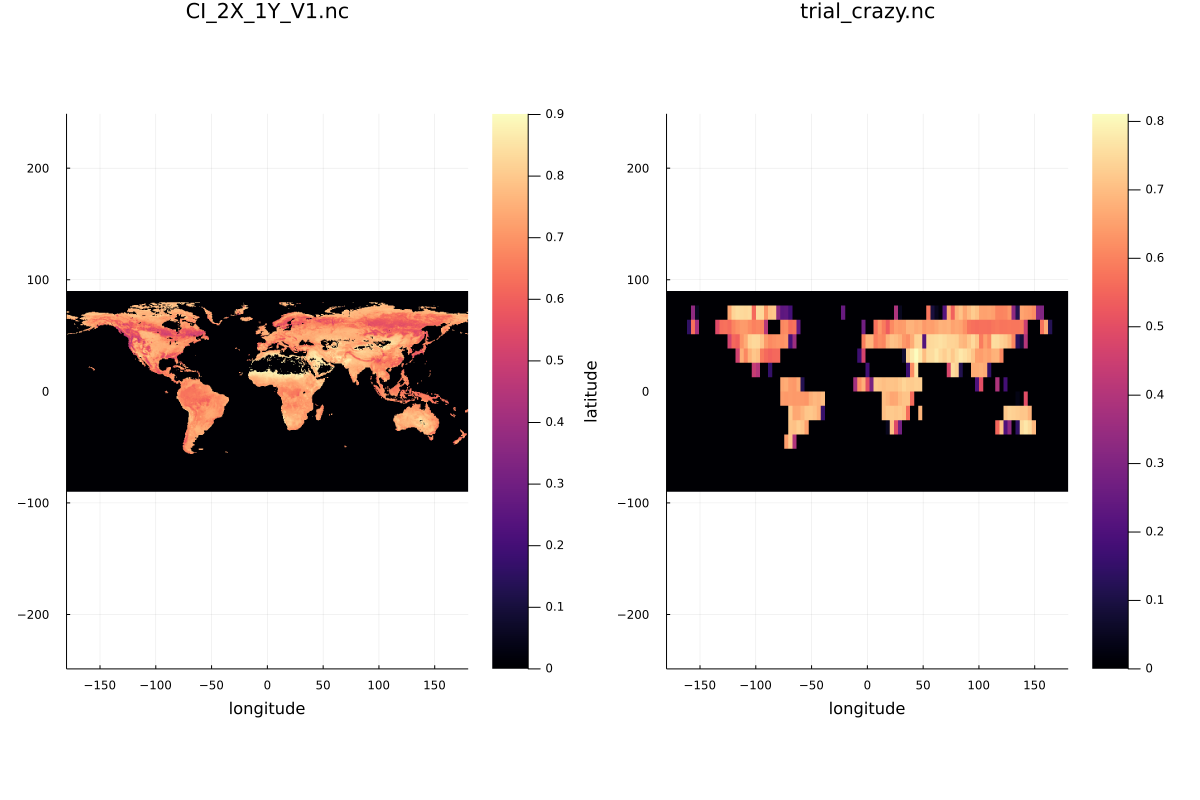

In [302]:
hmps = Dict("initial_data" => plot_ncdf(file),
            "regridded_data" => plot_ncdf(new_file))

plot(hmps["initial_data"], hmps["regridded_data"], layout = (1, 2))

In [317]:
rgo = Regridder2D(50,100)

Regridder2D{Int64, Float64}(RegridAxis{Int64, Float64}[RegridAxis{Int64, Float64}("lat", -90.0, 90.0, 50), RegridAxis{Int64, Float64}("lon", -180.0, 180.0, 100)])

In [11]:
new_file = "trial_sum.nc";

In [12]:
using StatsBase

In [13]:
regridding_op = StatsBase.variation

a=regrid2d_dataset(new_file, rgo, ds, ["data", "std"], regridding_op; force=true);

LoadError: UndefVarError: rgo not defined

In [15]:
hmps = Dict("initial_data" => plot_ncdf(file),
            "regridded_data" => plot_ncdf(new_file))

plot(hmps["initial_data"], hmps["regridded_data"], layout = (1, 2))
savefig("mytestplot.pdf")

In [ ]:
#savefig("mytestplot.pdf")